In [58]:
import importlib
import data_preprocessor
import helper_functions
import cluster_validation as cv
import cluster_plotting as cp
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

importlib.reload(data_preprocessor)
importlib.reload(helper_functions)
importlib.reload(cv)
importlib.reload(cp)

from helper_functions import load_dataset, save_dataset, save_cluster_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from data_preprocessor import DataPreprocessor
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, BisectingKMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [59]:
data_original = load_dataset("../data/assignment3_articles.xlsx")

## 1) Data Inspection and Preparation

First, we do some basic inspection of the dataset, such as checking the first few rows, the data types, the amount of missing values, and the value counts of certain columns.

In [60]:
data_original

index                                          headlines  \
0         0  Rupee ends 1 paisa lower at 83.38 against US d...   
1         1  India vs Syria Live Streaming, AFC Asian Cup 2...   
2         2  PM Modi to interact with VCs, teachers, studen...   
3         3  How to remove bloatware apps from Samsung, Rea...   
4         4  NEET SS 2023 result declared; counselling sche...   
...     ...                                                ...   
2495   2495  Google Search and Lens can now visualise STEM ...   
2496   2496  Arsenal’s Partey an injury doubt as Arteta rel...   
2497   2497  iQOO 12 will get 3 Android updates, will not h...   
2498   2498  Lava Blaze Pro 5G review: Is this the best 5G ...   
2499   2499  Karan Johar breaks down economics of cinema, r...   

                                            description  \
0     Besides, selling pressure in the domestic equi...   
1     AFC Asian Cup Live Streaming, India vs Syria F...   
2     G20 University Connect: The commission has ask...   
3     Smartphone companies often ship Android phones...   
4     NEET SS 2023 Result: Candidates who appeared f...   
...                                                 ...   
2495  Google Search and Lens can now help students w...   
2496  Partey came off at halftime during Arsenal's F...   
2497  iQOO says its upcoming flagship phone, running...   
2498  Lava Blaze Pro 5G is an excellent 5G smartphon...   
2499  Filmmaker Karan Johar spoke about the business...   

                                                content  
0     The rupee consolidated in a narrow range and s...  
1     India vs Syria AFC Asia Cup Live Streaming Det...  
2     The University Grants Commission (UGC) is orga...  
3     Smartphone manufacturers often pack new Androi...  
4     The National Board of Examinations Medical Sci...  
...                                                 ...  
2495  Google has been consistently improving its Sea...  
2496  Arsenal midfielder Thomas Partey is still an i...  
2497  iQOO is all set to launch its upcoming flagshi...  
2498  In less than a year, India has accounted for o...  
2499  Film production as a business is rife with ris...  

[2500 rows x 4 columns]

In [61]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        2500 non-null   int64 
 1   headlines    2500 non-null   object
 2   description  2500 non-null   object
 3   content      2500 non-null   object
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


### Preprocessing the text data

In [62]:
# Initialize the DataPreprocessor object
preprocessor = DataPreprocessor()

We quickly how below how the preprocessor works by applying it to the first row of the content column.

In [63]:
# get first row and last column
data_original.iloc[0, -1]

'The rupee consolidated in a narrow range and settled 1 paisa lower at 83.38 (provisional) against the US dollar on Tuesday, as investors preferred to remain cautious ahead of the domestic inflation data release and upcoming US Fed meeting.\nBesides, selling pressure in the domestic equity markets dented market sentiments, forex traders said.\nHowever, a weaker American currency against major currencies overseas restricted the loss in the local currency, they added.\nADVERTISEMENT\nAt the interbank foreign exchange market, the local unit opened at 83.36 and settled at 83.38 (provisional) against the greenback, registering a loss of 1 paisa from its previous close.\nDuring intra-day, the rupee touched a high of 83.35 and hit the lowest level of 83.39.\nOn Monday, the domestic currency settled at 83.37 against the US dollar.\nInvestors largely remained concerned over the domestic inflation data as well as industrial production numbers to be announced later in the day.\nADVERTISEMENT\nCur

In [64]:
preprocessor.preprocess_text(data_original.iloc[0, -1])

'rupe consolid narrow rang settl paisa lower provision us dollar tuesday investor prefer remain cautiou ahead domest inflat data releas upcom us fed meet besid sell pressur domest equiti market dent market sentiment forex trader said howev weaker american currenc major currenc oversea restrict loss local currenc ad interbank foreign exchang market local unit open settl provision greenback regist loss paisa previou close intraday rupe touch high hit lowest level monday domest currenc settl us dollar investor larg remain concern domest inflat data well industri product number announc later day currenc trader also await us feder reserv monetari polici decis like announc later week upcom focu us cpi data even expect per cent monthonmonth basi lower yearonyear figur per cent anticip mix reaction rupe seem unaffect persist within broad rang jateen trivedi vp research analyst lkp secur said meanwhil dollar index gaug greenback strength basket six currenc trade per cent lower tuesday brent cru

### Data Preprocessing

In [65]:
def count_numbers(text):
    """
    Count the occurrences of numbers in the text.
    """
    # match numbers
    pattern = r'\b\d+[,.]\d+\b|\b\d+[,.]?\b|\b[,.]\d+\b'
    return len(re.findall(pattern, text))

def count_integers(text):
    """
    Count the occurrences of integers in the text.
    """
    # match integers
    pattern = r'(?<![\.,])\b\d+\b(?![\.,])'
    return len(re.findall(pattern, text))

def count_floats(text):
    """
    Count the occurrences of floating point numbers in the text.
    """
    # match floating point numbers
    pattern = r'\b\d+[\.,]\d+\b'
    return len(re.findall(pattern, text))

def preprocess_col(preprocessor: DataPreprocessor, col: pd.Series, h_pct: float = 0, l_pct: float = 0) -> pd.Series:
    """ 
    Preprocesses a column of text data using the preprocessor (cfr. data_preprocessor.py), 
    and by removing the top $h_pct of the most frequent words and the top $l_pct of the least frequent words.
    
    Inspired partly by: https://medium.com/analytics-vidhya/introduction-to-text-classification-in-python-659eccf6b2e
    
    :param preprocessor: preprocessor object
    :param col: column of text data
    :param h_pct: "the percentage of high frequency words to remove from the corpus"
    :param l_pct: "the percentage of low frequency words to remove from the corpus"
    :return: preprocessed column
    """

    col = col.apply(preprocessor.preprocess_text)
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(col).split()).value_counts()[:int(pd.Series(' '.join(col).split()).count()*h_pct/100)]
        rem_high = col.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = col
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

We concatenate the headlines, descriptions, and preprocessed content columns into a single column, and preprocess the concatenated column.

In [66]:
data = data_original.copy()
# count amount of numbers in content column
data['amount_of_integers'] = data['content'].apply(count_integers)
data['amount_of_floats'] = data['content'].apply(count_floats)

# remove news site subscriber stuff, I got this from Inte Vleminckx. We were in call while he was going through the dataset for these:

data = data.replace("""Register to read more stories
Continue With:-
Google
Facebook
Email
Already have an account? Sign in""", '')
data = data.replace('Click for more updates and latest Bollywood news along with Entertainment updates. Also get latest news and top headlines from India and around the world at The Indian Express.', '')
data = data.replace("""(‘My dear students’, a fortnightly column that is a conversation with young minds on current events, books, popular culture — just about anything that’s worth talking over a cup of coffee.)
My dear students,
This story is subscriber only!

Now subscribe at a special discount of 15% Use Code: ELECTION15
Subscribe Now
Already a subscriber? Sign in""", '')
data = data.replace("""This premium article is free for now..
Register to continue reading.
Register""", '')
data = data.replace('Already a subscriber? Sign in', '')
data = data.replace('Already have an account? Sign in', '')
data = data.replace('You have exhausted your monthly limit of free stories.', '')
data = data.replace('CLICK HERE FOR MORE', '')
data = data.replace('BUY NOW', '')
data['content'] = data['content'].replace('Register', '')

data['preprocessed_content'] = preprocess_col(preprocessor, data['content'], h_pct=1, l_pct=1)
data['concatenated'] = data['headlines'] + ' ' + data['description'] + ' ' + data['preprocessed_content']
data['preprocessed_concat'] = preprocess_col(preprocessor, data['concatenated'], h_pct=0, l_pct=0)

data_preprocessed = data.drop(columns=['headlines', 'description', 'content', 'preprocessed_content', 'concatenated'])

In [67]:
data_preprocessed

index  amount_of_integers  amount_of_floats  \
0         0                   3                21   
1         1                   4                 0   
2         2                   3                 0   
3         3                   0                 0   
4         4                   2                 0   
...     ...                 ...               ...   
2495   2495                   0                 0   
2496   2496                   1                 0   
2497   2497                   9                 0   
2498   2498                   1                 0   
2499   2499                   1                 0   

                                    preprocessed_concat  
0     rupe end paisa lower us dollar besid sell pres...  
1     india vs syria live stream afc asian cup watch...  
2     pm modi interact vc teacher student ugc univer...  
3     remov bloatwar app samsung realm xiaomi vivo r...  
4     neet ss result declar counsel schedul soon nat...  
...                                                 ...  
2495  googl search len visualis stem model help calc...  
2496  arsen partey injuri doubt arteta reli jorginho...  
2497  iqoo get android updat hot app hot game iqoo s...  
2498  lava blaze pro review best phone rs lava blaze...  
2499  karan johar break econom cinema reveal busi mo...  

[2500 rows x 4 columns]

We vectorize the preprocessed text data using the TF-IDF method.

In [68]:
vectorizer = TfidfVectorizer(min_df=5)
# vectorizer = CountVectorizer()
vectorized_data = vectorizer.fit_transform(data_preprocessed['preprocessed_concat']) # Vectorize preprocessed text data
vectorized_data_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_features = vectorized_data_df.copy()

In [69]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# number_of_integers_scaled = scaler.fit_transform(data_preprocessed[['amount_of_integers']])
# number_of_floats_scaled = scaler.fit_transform(data_preprocessed[['amount_of_floats']])
# Combine TF-IDF features with the normalized count columns
# combined_features = np.hstack((tfidf_features, number_of_integers_scaled, number_of_floats_scaled))
# tfidf_features = pd.DataFrame(combined_features, columns=list(vectorizer.get_feature_names_out()) + ['amount_of_integers', 'amount_of_floats'])

In [70]:
tfidf_features

aaa  aamir   ab  abandon  abc  abhishek  abil  abl  abraham  abrar  ...  \
0     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
1     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
2     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
3     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
4     0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
...   ...    ...  ...      ...  ...       ...   ...  ...      ...    ...  ...   
2495  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
2496  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
2497  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
2498  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   
2499  0.0    0.0  0.0      0.0  0.0       0.0   0.0  0.0      0.0    0.0  ...   

      youll  young  youngest  your  youth  youtub  yrf  zealand  zero  zone  
0       0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
1       0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
2       0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
3       0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
4       0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
...     ...    ...       ...   ...    ...     ...  ...      ...   ...   ...  
2495    0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
2496    0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
2497    0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
2498    0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  
2499    0.0    0.0       0.0   0.0    0.0     0.0  0.0      0.0   0.0   0.0  

[2500 rows x 4312 columns]

In [71]:
from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model
n_topics = 5  # Number of topics to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(vectorized_data)

# Get the topic distribution for each document
topic_distribution = lda.transform(vectorized_data)
d = data.copy()
d['topic'] = np.argmax(topic_distribution, axis=1)

In [72]:
d['topic'].value_counts()

topic
2    811
1    681
0    382
3    377
4    249
Name: count, dtype: int64

In [73]:
# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

n_top_words = 20
print("Topics in LDA model:")
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

# Count the number of articles for each topic
topic_counts = d['topic'].value_counts()
print("Number of articles per topic:")
print(topic_counts)

Topics in LDA model:
Topic #0:
test vs cuet australia india cricket world kohli ind khan cup team au virat play run women pakistan first sharma
Topic #1:
rs per cent crore india market share point tech new us news sensex price galaxi bank launch trade watch sale
Topic #2:
exam result student ug univers offici check websit class neet candid year board releas india iit jee counsel programm new
Topic #3:
film shah rukh khan box collect offic day kapoor ai rs anim dunki crore salaar ranbir new director year make
Topic #4:
kapoor khan boss india bigg gold fund say anim watch ranbir said game nanda rs mandanna ira video ankita bank

Number of articles per topic:
topic
2    811
1    681
0    382
3    377
4    249
Name: count, dtype: int64


### Clustering

In [74]:
RANDOM_STATE = 42
DIM_REDUCTION_COMPONENTS = 20
MAX_K = 12
STATISTICS_N_PERMUTATIONS = 10
NUM_CLUSTERS = 5 # set after elbow method and others

### KMedoids

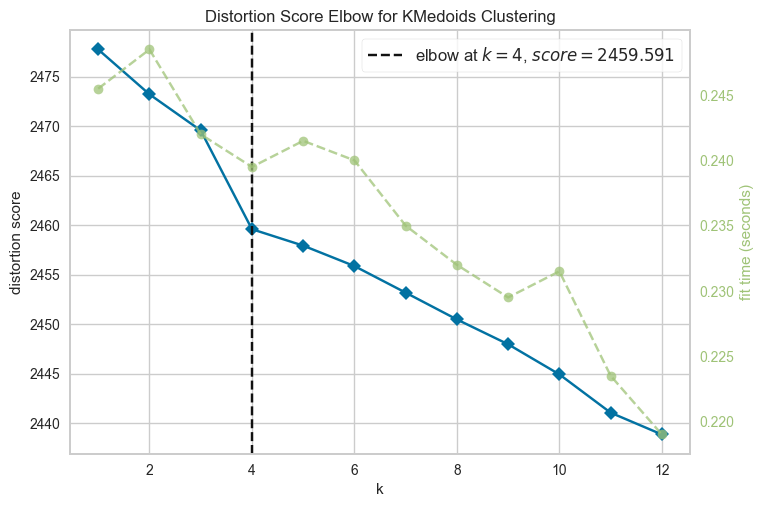

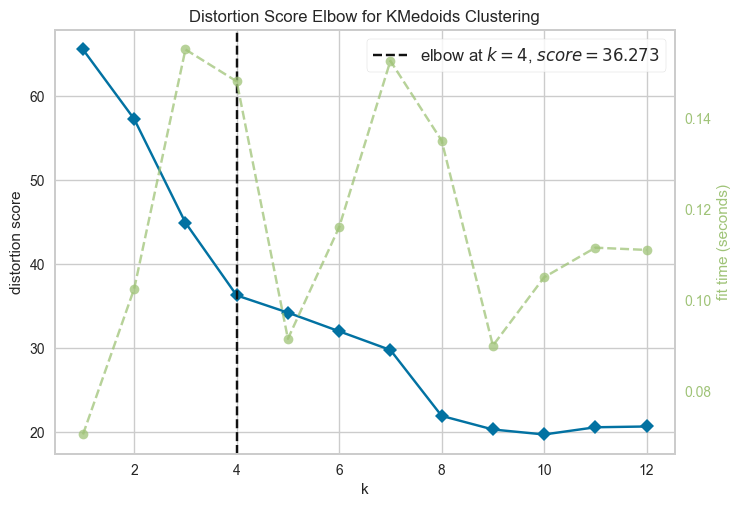

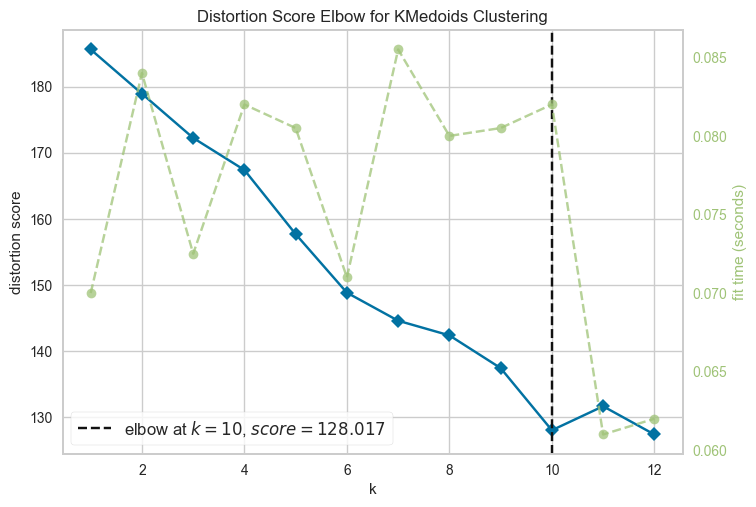

In [75]:
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'), vectorized_data_df, max_k=MAX_K)
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'),TruncatedSVD(n_components=5, random_state=RANDOM_STATE).fit_transform(tfidf_features), max_k=MAX_K)
cp.elbow_method_plot(KMedoids(random_state=RANDOM_STATE, metric='cosine'), TruncatedSVD(n_components=DIM_REDUCTION_COMPONENTS, random_state=RANDOM_STATE).fit_transform(tfidf_features), max_k=MAX_K)

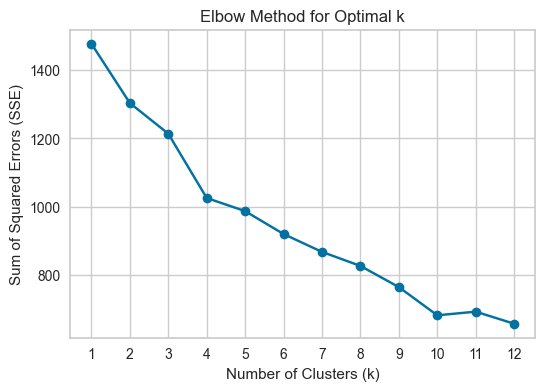

In [76]:
sse = []  # List to store SSE values for different k
n_init = 100
max_k = MAX_K
for k in range(1, max_k + 1):
    best_inertia = float('inf')
    for i in range(n_init):
        random_state = i
        model_k = KMedoids(n_clusters=k, random_state=RANDOM_STATE, metric='cosine', init='k-medoids++')
        model_k.fit(TruncatedSVD(n_components=DIM_REDUCTION_COMPONENTS, random_state=RANDOM_STATE).fit_transform(tfidf_features))
        if model_k.inertia_ < best_inertia:
          best_inertia = model_k.inertia_
    sse.append(best_inertia)

# Plot SSE vs. number of clusters (k)
plt.figure(figsize=(6, 4))
plt.plot(range(1, max_k + 1), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

In [77]:
def run_kmedoids_multiple_times(data, num_clusters, num_runs, metric='cosine', init='k-medoids++'):
    """
    Run KMedoids clustering multiple times and keep track of the best model using SSE.
    :param model: KMedoids model
    :param data: data to cluster
    :param num_clusters: number of clusters
    :param num_runs: number of runs
    :param random_state: random state
    :param verbose: print results
    :return: best model
    """
    models = []
    for i in range(num_runs):
        random_state = i
        model = KMedoids(n_clusters=num_clusters, metric=metric, random_state=random_state, init=init)
        model.fit(data)
        cluster_labels = model.labels_
        sse = model.inertia_
        
        # Calculate label counts and standard deviation of the counts
        label_counts = np.bincount(cluster_labels)
        max_count = label_counts.max()
        std_dev = np.std(label_counts)
        
        # Only save the model if the highest count of any label does not exceed 700
        if max_count <= 700:
            models.append((model, cluster_labels, sse, std_dev))
            
    # Sort the models by standard deviation of label counts in ascending order
    models.sort(key=lambda x: x[2])
    # Print the results
    for m in models:
        kmedoids, cluster_labels, sse, std_dev = m
        print(f"Model: {kmedoids} SSE: {sse}")
        print(f"Label Distribution: {' '.join([f'{i}: {v}' for i, v in enumerate(np.bincount(cluster_labels))])}")
        print(f"Standard Deviation of Label Counts: {std_dev:.2f}")
        print()

In [78]:
run_kmedoids_multiple_times(TruncatedSVD(n_components=20, random_state=42).fit_transform(tfidf_features), num_clusters=5, num_runs=300, metric='cosine', init='k-medoids++')

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=273) SSE: 915.6791813260361
Label Distribution: 0: 535 1: 456 2: 629 3: 484 4: 396
Standard Deviation of Label Counts: 78.58

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=12) SSE: 924.1046769874922
Label Distribution: 0: 545 1: 497 2: 390 3: 449 4: 619
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=91) SSE: 924.1046769874922
Label Distribution: 0: 390 1: 545 2: 619 3: 449 4: 497
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=142) SSE: 924.1046769874922
Label Distribution: 0: 449 1: 390 2: 545 3: 497 4: 619
Standard Deviation of Label Counts: 78.61

Model: KMedoids(init='k-medoids++', metric='cosine', n_clusters=5, random_state=157) SSE: 924.1046769874922
Label Distribution: 0: 497 1: 545 2: 449 3: 390 4: 619
Standard Deviat

In [79]:
run_kmedoids_multiple_times(TruncatedSVD(n_components=20, random_state=42).fit_transform(tfidf_features), num_clusters=5, num_runs=300, metric='jaccard', init='k-medoids++')

In [80]:
def kmedoids_clustering(df, num_clusters, random_state, init='k-medoids++', plot=False, precomputed=False, metric='euclidean', n_permutations=STATISTICS_N_PERMUTATIONS):
    """
    Perform Kmedoids clustering on the dataset.
    :param df: 
    :param n_clusters: 
    :param random_state: 
    :param n_init: 
    :param init: 
    :param plot: 
    :param precomputed: 
    :param metric: 
    :param n_permutations: 
    :return: 
    """
    bkmeans = KMedoids(n_clusters=num_clusters, random_state=random_state, init=init, metric=metric)
    bkmeans.fit(df)
    cluster_labels = bkmeans.labels_

    # Assign cluster labels to documents in the dataset
    labels = tfidf_features.copy()
    labels['cluster'] = cluster_labels

    print(labels['cluster'].value_counts())
    
    stats_bkm = cv.cv_statistics(bkmeans, cluster_labels, df, num_clusters, metric=metric, n_permutations=n_permutations, verbose=False)
    
    cv.cv_similarity_matrix(df, cluster_labels, metric=metric, precomputed=precomputed)
    
    if plot:
        cp.plot_clusters_2d_all(df.values, cluster_labels)
        cp.plot_clusters_3d_all(df.values, cluster_labels)
    
    return bkmeans, cluster_labels

cluster
0    933
2    681
1    462
3    244
4    180
Name: count, dtype: int64
---
Actual Inertia: 2342.8649
Random Inertia: Mean: 2397.0131, Std: 5.7671
Inertia Z-Score: -9.3892 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0032
Random Silhouette: Mean: -0.0033, Std: 0.0015
Silhouette Z-Score: 4.2732 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.1070
Random Correlation: Mean: -0.0474, Std: 0.0085
Correlation Z-Score: -7.0164 => Correlation is Atypical: True
---


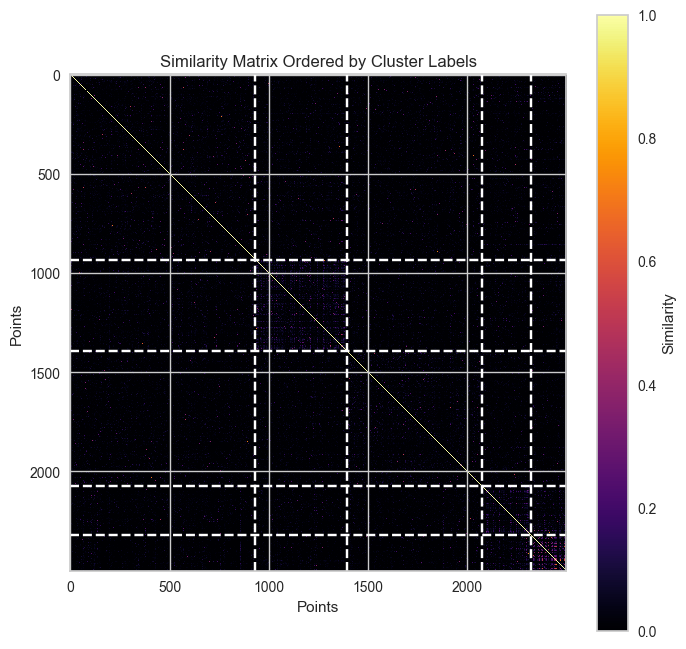

In [81]:
kmedoids1, labels1 = kmedoids_clustering(tfidf_features, num_clusters=5, random_state=279, plot=False, metric='cosine')

cluster
4    625
0    525
1    506
2    436
3    408
Name: count, dtype: int64
---
Actual Inertia: 940.1418
Random Inertia: Mean: 1341.4986, Std: 39.1627
Inertia Z-Score: -10.2484 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0387
Random Silhouette: Mean: 0.0275, Std: 0.0142
Silhouette Z-Score: 0.7925 => Silhouette Score is Atypical: False
---
Actual Correlation: -0.4551
Random Correlation: Mean: -0.2634, Std: 0.0431
Correlation Z-Score: -4.4448 => Correlation is Atypical: True
---


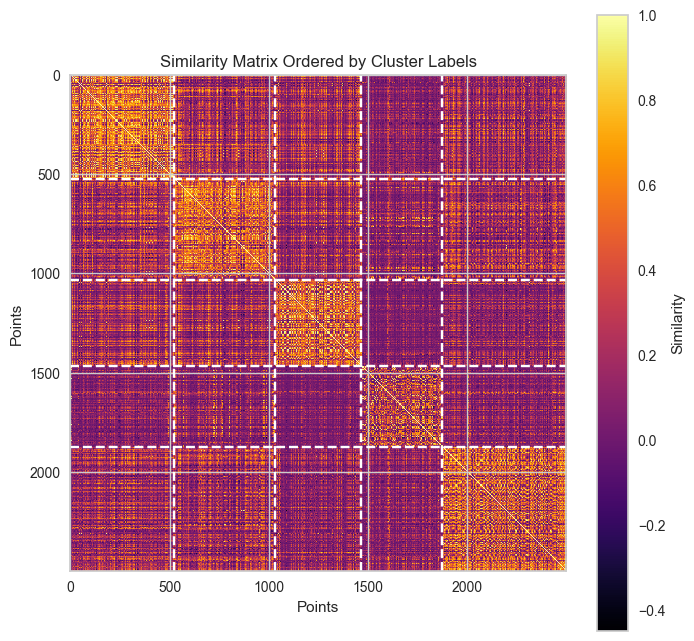

In [82]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=5, random_state=279, plot=False, metric='cosine', init='random')
save_cluster_labels(data_original, labels2, '../output/cluster_assignments/kmedoids_1.xlsx')

cluster
2    554
0    544
4    528
3    462
1    412
Name: count, dtype: int64
---
Actual Inertia: 933.4061
Random Inertia: Mean: 1334.7463, Std: 26.8775
Inertia Z-Score: -14.9322 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0581
Random Silhouette: Mean: 0.0268, Std: 0.0085
Silhouette Z-Score: 3.6653 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.4602
Random Correlation: Mean: -0.2546, Std: 0.0202
Correlation Z-Score: -10.1613 => Correlation is Atypical: True
---


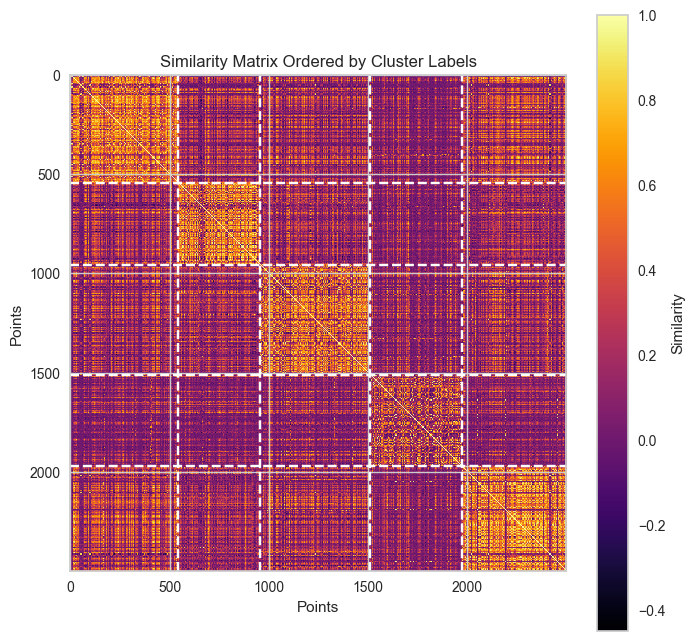

In [83]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=5, random_state=207, plot=False, metric='cosine', init='k-medoids++')
save_cluster_labels(data_original, labels2, '../output/cluster_assignments/kmedoids_2.xlsx')

cluster
2    1063
3     703
0     408
1     326
Name: count, dtype: int64
---
Actual Inertia: 1123.9246
Random Inertia: Mean: 1398.6447, Std: 40.0354
Inertia Z-Score: -6.8619 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0476
Random Silhouette: Mean: 0.0273, Std: 0.0093
Silhouette Z-Score: 2.1690 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.3070
Random Correlation: Mean: -0.2215, Std: 0.0353
Correlation Z-Score: -2.4218 => Correlation is Atypical: True
---


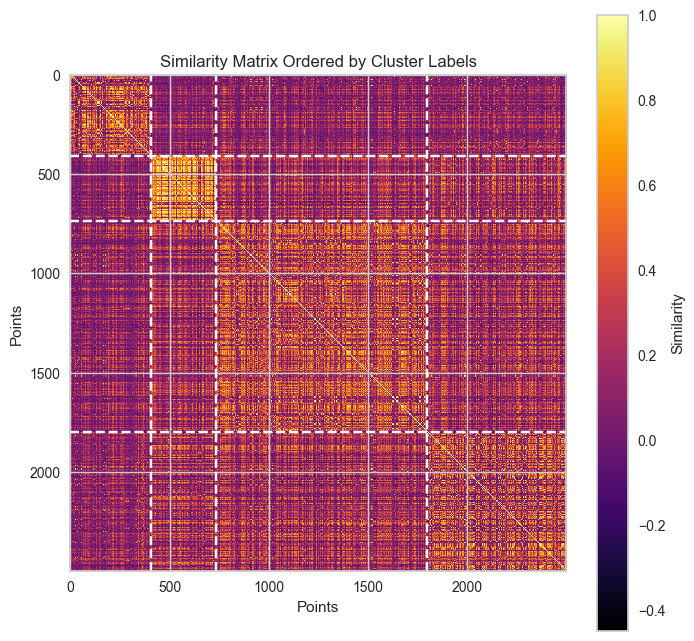

In [84]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=4, random_state=207, plot=False, metric='cosine', init='random')

cluster
0    1055
2     489
1     485
3     471
Name: count, dtype: int64
---
Actual Inertia: 1058.6819
Random Inertia: Mean: 1377.6143, Std: 46.0462
Inertia Z-Score: -6.9263 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0658
Random Silhouette: Mean: 0.0244, Std: 0.0107
Silhouette Z-Score: 3.8743 => Silhouette Score is Atypical: True
---
Actual Correlation: -0.4342
Random Correlation: Mean: -0.2361, Std: 0.0245
Correlation Z-Score: -8.0755 => Correlation is Atypical: True
---


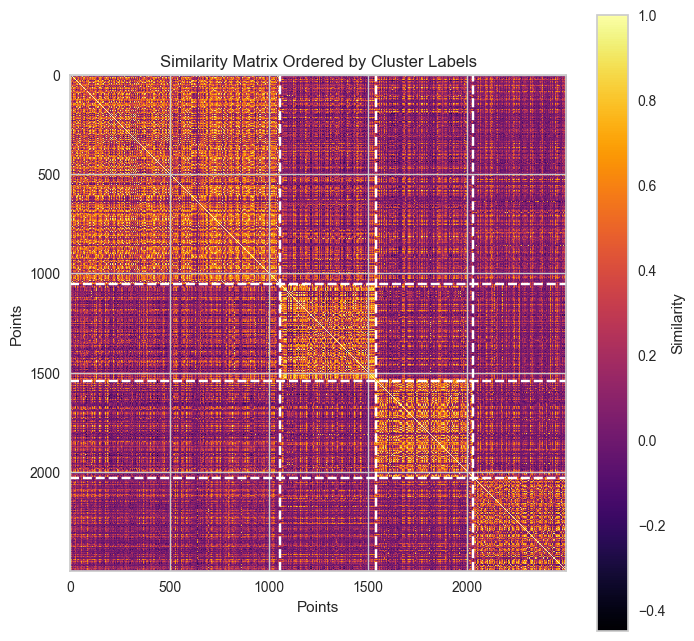

In [85]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=4, random_state=207, plot=False, metric='cosine', init='k-medoids++')

cluster
2    932
5    413
4    330
0    302
3    282
1    241
Name: count, dtype: int64
---
Actual Inertia: 962.4193
Random Inertia: Mean: 1304.6981, Std: 40.9373
Inertia Z-Score: -8.3611 => Inertia is Atypical: True
---
Actual Silhouette Score: -0.0167
Random Silhouette: Mean: 0.0208, Std: 0.0072
Silhouette Z-Score: -5.1723 => Silhouette Score is Atypical: False
---
Actual Correlation: -0.3802
Random Correlation: Mean: -0.2512, Std: 0.0261
Correlation Z-Score: -4.9352 => Correlation is Atypical: True
---


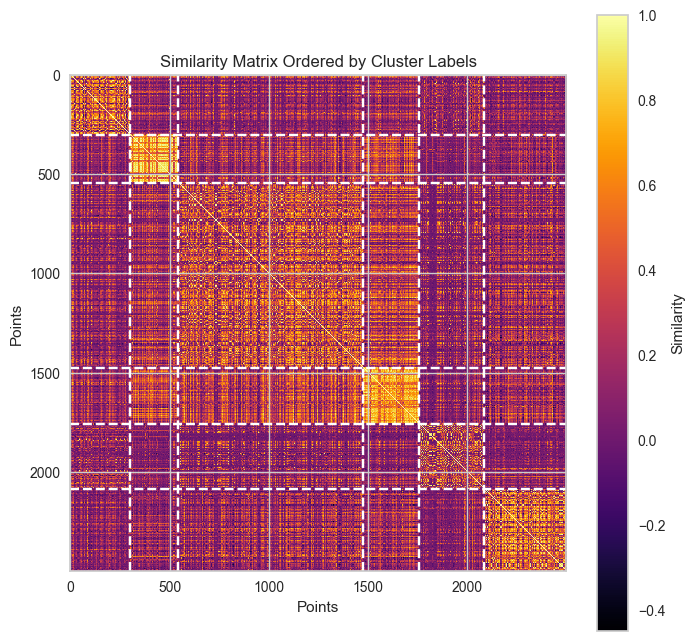

In [86]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=6, random_state=207, plot=False, metric='cosine', init='random')

cluster
0    537
4    464
3    441
2    426
1    382
5    250
Name: count, dtype: int64
---
Actual Inertia: 908.7948
Random Inertia: Mean: 1283.8394, Std: 43.4876
Inertia Z-Score: -8.6242 => Inertia is Atypical: True
---
Actual Silhouette Score: -0.0252
Random Silhouette: Mean: 0.0273, Std: 0.0076
Silhouette Z-Score: -6.9364 => Silhouette Score is Atypical: False
---
Actual Correlation: -0.4442
Random Correlation: Mean: -0.2663, Std: 0.0322
Correlation Z-Score: -5.5204 => Correlation is Atypical: True
---


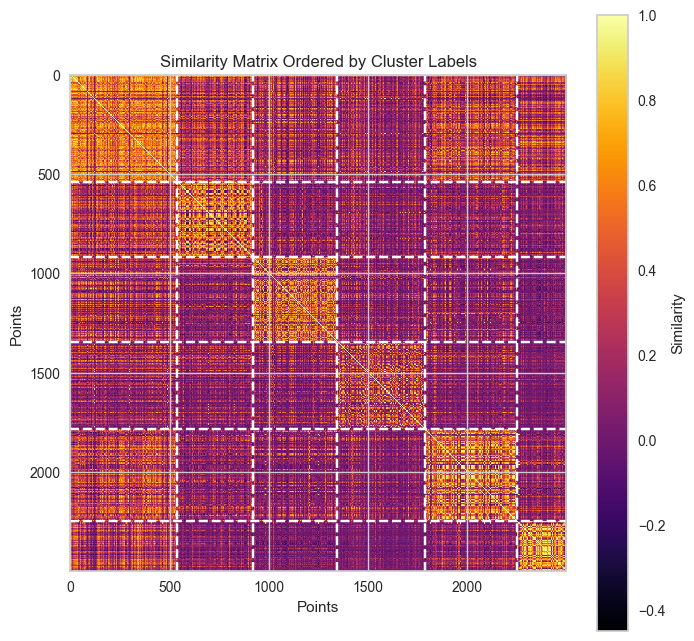

In [87]:
kmedoids2, labels2 = kmedoids_clustering(TruncatedSVD(n_components=20, random_state=RANDOM_STATE).fit_transform(tfidf_features), num_clusters=6, random_state=207, plot=False, metric='cosine', init='k-medoids++')

In [88]:
kmedoids3, labels3 = kmedoids_clustering(tfidf_features, num_clusters=5, random_state=207, plot=False, metric='jaccard', init='k-medoids++')

cluster
0    896
3    553
1    434
4    349
2    268
Name: count, dtype: int64
---
Actual Inertia: 2399.2210
Random Inertia: Mean: 2423.8748, Std: 3.1922
Inertia Z-Score: -7.7231 => Inertia is Atypical: True
---
Actual Silhouette Score: 0.0020
Random Silhouette: Mean: -0.0038, Std: 0.0016
Silhouette Z-Score: 3.6306 => Silhouette Score is Atypical: True
---
Actual Correlation: nan
Random Correlation: Mean: nan, Std: nan
Correlation Z-Score: nan => Correlation is Atypical: False
---


AttributeError: 'DataFrame' object has no attribute 'dtype'